In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from random import random
from scipy.optimize import minimize
from statsmodels.stats.multitest import multipletests
from numpy import array,empty
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
import cmasher as cmr
warnings.filterwarnings("ignore")
import time
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d
from scipy import stats

# Read metadata

In [3]:
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin'] # focus on inulin
df_scfa = pd.read_csv('../../../our_data/SCFA.csv', index_col=0)
df_meta_scfa = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_meta_scfa.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,Acetate,Propionate,Butyrate,Total
SampleID,,,,,,,,,
sample141,BI1,Beijing,0,Inulin,A,5.233899,1.930933,1.109582,8.702693
sample142,BI2,Beijing,0,Inulin,B,13.459823,3.621771,1.546647,19.235932
sample143,BI3,Beijing,0,Inulin,D,18.075378,2.859916,1.682656,23.217751
sample144,BI4,Beijing,0,Inulin,E,12.580368,3.148773,1.477688,17.614381
sample145,BI5,Beijing,0,Inulin,C,8.065127,3.134209,1.835172,13.577951


# Fit harmonic oscillator model (for each SCFA and each mice)

In [4]:
def overdampling(params,xdata):
    k1,k2,D,H,Ai = params
    ypred = H/k1/k2+((D+k2*Ai-H/k1)*np.exp(-k1*xdata)-(D+k1*Ai-H/k2)*np.exp(-k2*xdata))/(k2-k1)
    return ypred

In [5]:
def residual(params,xdata,ydata):
    ypred = overdampling(params,xdata)
    #return mean_squared_error(ydata, ypred)
    return -r2_score(ydata, ypred)

In [6]:
all_scfa = ['Acetate','Butyrate','Propionate']
all_mice = list(set(df_meta_scfa.MiceID))
all_vendor = list(set(df_meta_scfa.Vendor))

lines = []
for i, scfa_ in enumerate(all_scfa):
    for j, mice_ in enumerate(all_mice):
        curr_df = df_meta_scfa[df_meta_scfa.MiceID==mice_].sort_values(by='Day')
        vendor_ = list(set(curr_df.Vendor))[0]
        
        # get X and Y data
        xdata = np.array(curr_df.Day)
        ydata = np.array(curr_df[scfa_])

        # model fitting
        min_obj_over = 1e10
        best_sol_over = None
        trial=0
        while trial < 100:
            try:
#                 res = minimize(residual, 
#                                [random(),random(),random(),random(),random()], 
#                                args=(xdata,ydata),
#                                bounds = ((0, 1), (0, 1), (0, None), (0, None), (0,None)),
#                                method='Powell', # Powell
#                                tol=1e-8,
#                                options={'maxiter':1000}
#                               )
                res = minimize(residual, 
                   [random(),random(),random(),random(),ydata[0]], 
                   args=(xdata,ydata),
                   bounds = ((0, 1), (0, 1), (0, None), (0, None), (ydata[0],ydata[0])),
                   method='Powell', # Powell
                   tol=1e-8,
                   options={'maxiter':1000}
                  )
                assert res.success==True
                if res.fun < min_obj_over:
                    best_sol_over = res.x
                    min_obj_over = res.fun
                trial += 1
            except:
                pass
        print(scfa_, mice_)
        print(best_sol_over)
        lines.append([mice_, vendor_, scfa_] + list(best_sol_over) + [r2_score(ydata, overdampling(best_sol_over, xdata))])

    # write to file
    df_best_fit = pd.DataFrame(lines, columns=['MiceID','Vendor','SCFA','k1','k2','D','H','Ai','R2'])
    df_best_fit['zeta'] = [(k1+k2)/2/np.sqrt(k1*k2) for k1,k2 in zip(df_best_fit['k1'],df_best_fit['k2'])]
    df_best_fit.to_excel('best_fit_parameters_r2_fixedIC.xlsx')

Acetate BI1
[ 0.57480101  0.57480096 23.76110267  5.38859066  5.23389922]
Acetate GI3
[ 0.42695631  0.42695631 18.90851774  3.7350377   8.6126283 ]
Acetate SI1
[ 0.22256095  0.22256096 17.03294816  0.37051595  3.65146118]
Acetate BI3
[ 0.77825281  0.77825308 45.88857191 10.19197599 18.07537795]
Acetate BI4
[5.35665441e-10 9.99999787e-01 4.93215217e+00 1.12027743e-01
 1.25803680e+01]
Acetate GI1
[1.07415003e-09 3.46375128e-01 2.62968467e+00 7.41827024e-02
 1.24667730e+01]
Acetate SI3
[ 0.43577076  0.43577058 16.09860302  1.79686536  5.0557566 ]
Acetate HI4
[ 0.08815192  0.08815216  1.31528275  0.07215316 11.09616374]
Acetate BI5
[ 0.06412623  1.         11.96429262  0.66563331  8.06512734]
Acetate HI5
[ 0.23522673  0.23522675  4.65061544  0.66295558 13.79321843]
Acetate HI2
[ 0.39003853  0.39003821 15.52490215  2.13348382  2.06124266]
Acetate SI2
[ 0.30686742  0.30686743  8.59155273  1.20222756 20.0154278 ]
Acetate GI4
[0.03023061 0.28954893 7.93554762 0.01677101 8.4866322 ]
Acetate BI2

In [7]:
colors = cmr.take_cmap_colors('jet', 5, return_fmt='hex')
print(colors)

['#000080', '#0080FF', '#7DFF7A', '#FF9800', '#800000']


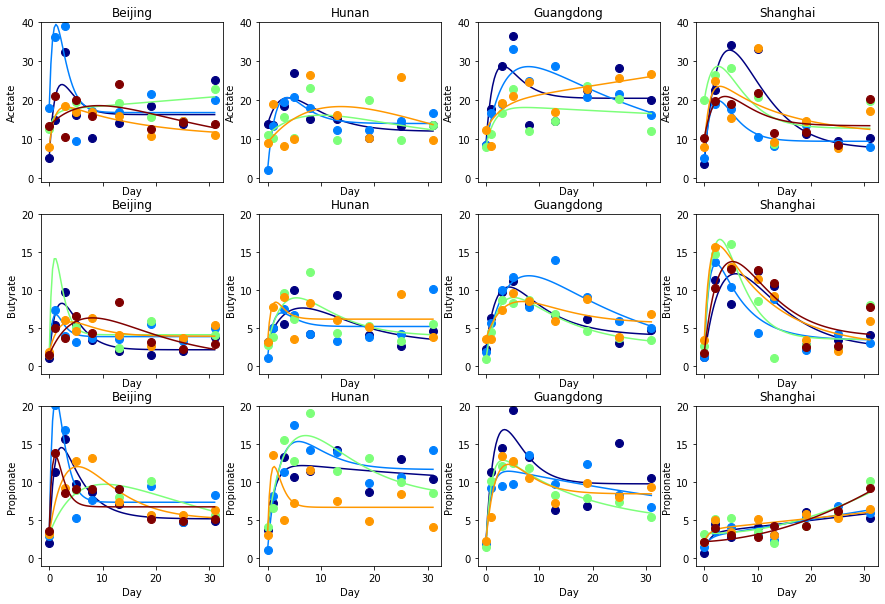

In [8]:
fig, ax = plt.subplots(figsize=(15, 10), nrows=3, ncols=4, sharex=True)
df_best_fit = pd.read_excel('best_fit_parameters_r2_fixedIC.xlsx', index_col=0)

colors= ['#000080', '#0080FF', '#7DFF7A', '#FF9800', '#800000']
for i, scfa_ in enumerate(all_scfa):
    for j, vendor_ in enumerate(all_vendor):
        curr_df = df_meta_scfa[df_meta_scfa.Vendor==vendor_]
        for k, mice_ in enumerate(set(curr_df.MiceID)):
            curr_df2 = curr_df[curr_df.MiceID==mice_].sort_values(by='Day')
            
            # get X and Y data
            xdata = np.array(curr_df2.Day)
            ydata = np.array(curr_df2[scfa_])
            ax[i,j].plot(xdata, ydata, marker='o', linestyle = 'None', markersize=8, color=colors[k])

            xdata_dense = np.linspace(0,31,100)
            best_sol_over = df_best_fit.loc[(df_best_fit.MiceID==mice_)&(df_best_fit.SCFA==scfa_), ['k1','k2','D','H','Ai']].values[0]
            ypred = overdampling(best_sol_over, xdata_dense)
            ax[i,j].plot(xdata_dense, ypred, color=colors[k])
            ax[i,j].set_title(vendor_)
            ax[i,j].set_xlabel('Day')
            ax[i,j].set_ylabel(scfa_)

            if i==0:
                ax[i,j].set_ylim([-1,40])
            if i==1:
                ax[i,j].set_ylim([-1,20])
            if i==2:
                ax[i,j].set_ylim([-1,20])
                
# plt.tight_layout()
# plt.savefig('scfa_dynamics_model_fit_inulin.eps', format='eps')